In [1]:
from pandas_datareader import data as pdr
from pandas_datareader.data import DataReader
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
%matplotlib inline
import numpy as np
import statsmodels.api as sm

E:\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
df = pd.read_csv(r'..\EDA\techlist.csv')

df['Date'] = pd.to_datetime(df['Date'])
# Set the date as index 
df = df.set_index('Date')
# Select the proper time period for weekly aggreagation
df = df['2018-01-02':'2020-12-05'].resample('W').sum()
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-07,10163.682434,10013.425491,10040.075577,10133.565929,7.167720e+08,10101.895947
2018-01-14,13155.547913,12967.656921,13024.243607,13121.318867,8.023109e+08,13081.715023
2018-01-21,10837.357922,10635.467655,10774.473415,10722.674427,8.526005e+08,10690.583588
2018-01-28,14021.610355,13758.998554,13878.689884,13946.806080,1.153956e+09,13906.056862
2018-02-04,14432.881454,14069.486473,14269.350533,14195.301777,1.509056e+09,14154.824360


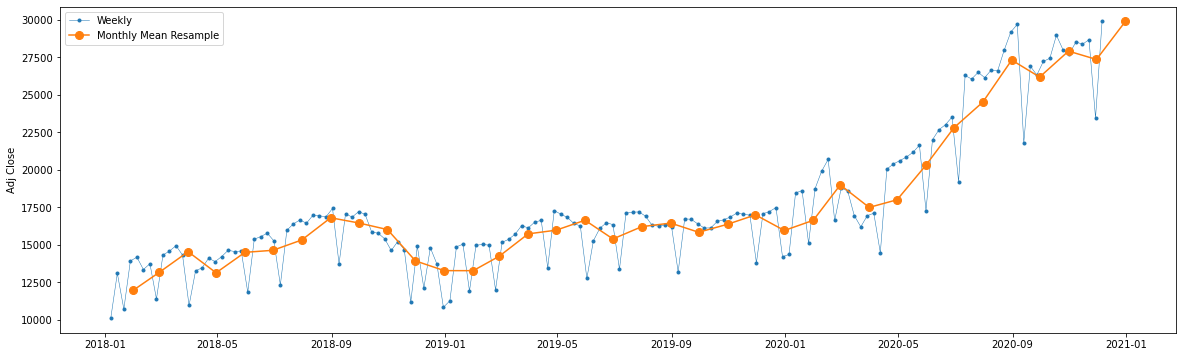

In [3]:
adj_close = df['Adj Close']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(adj_close,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(adj_close.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Adj Close')
ax.legend();

Decompose the data to view more of the complexity behind the linear visualization. 

A useful Python function called seasonal_decompose within the 'statsmodels' package can help us to decompose the data into four different components

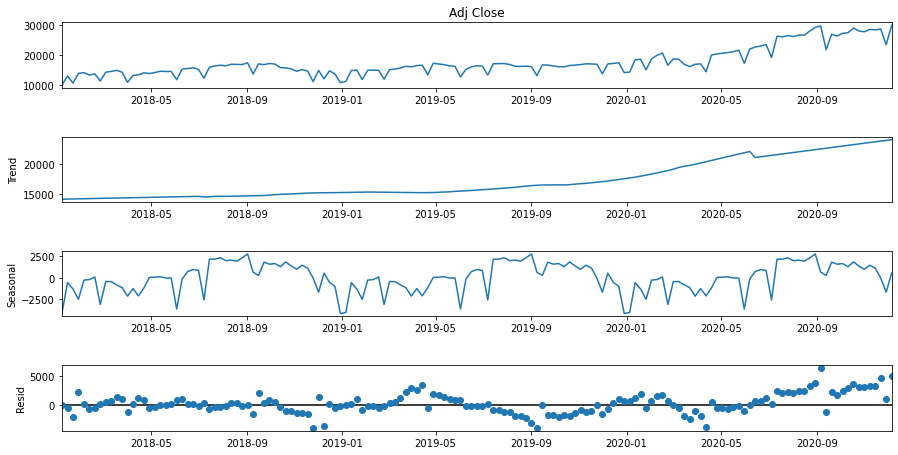

In [4]:
# graphs to show seasonal_decompose
def seasonal_decompose (adj_close):
    decomposition = sm.tsa.seasonal_decompose(adj_close, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()
    
seasonal_decompose(adj_close)

### Check for Stationarity:
Next, we need to check whether the dataset is stationary or not. A dataset is stationary if its statistical properties like mean, variance, and autocorrelation do not change over time.

Most time series datasets related to business activity are not stationary since there are usually all sorts of non-stationary elements like trends and economic cycles. But, since most time series forecasting models use stationarity—and mathematical transformations related to it—to make predictions, we need to ‘stationarize’ the time series as part of the process of fitting a model.

Two common methods to check for stationarity are Visualization and the Augmented Dickey-Fuller (ADF) Test. Python makes both approaches easy:

### Visualization
This method graphs the rolling statistics (mean and variance) to show at a glance whether the standard deviation changes substantially over time:

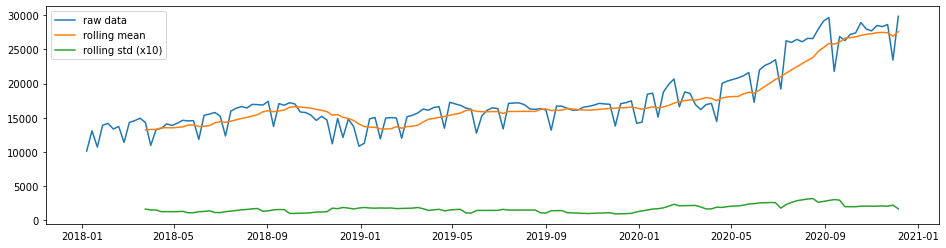

In [5]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(adj_close,'raw data')

### Another test of stationarity
### Augmented Dickey-Fuller Test
The ADF approach is essentially a statistical significance test that compares the p-value with the critical values and does hypothesis testing. Using this test, we can determine whether the processed data is stationary or not with different levels of confidence

In [6]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
        
ADF_test(adj_close,'raw data')

 > Is the raw data stationary ?
Test statistic = 0.404
P-value = 0.982
Critical values :
	1%: -3.4753253063120644 - The data is not stationary with 99% confidence
	5%: -2.881274703275226 - The data is not stationary with 95% confidence
	10%: -2.5772928360116873 - The data is not stationary with 90% confidence


### Make the Data Stationary
we’ll use de-trending, differencing, and then a combination of the two.

### Detrending
This method removes the underlying trend in the time series:

 > Is the de-trended data stationary ?
Test statistic = -4.040
P-value = 0.001
Critical values :
	1%: -3.47864788917503 - The data is  stationary with 99% confidence
	5%: -2.882721765644168 - The data is  stationary with 95% confidence
	10%: -2.578065326612056 - The data is  stationary with 90% confidence


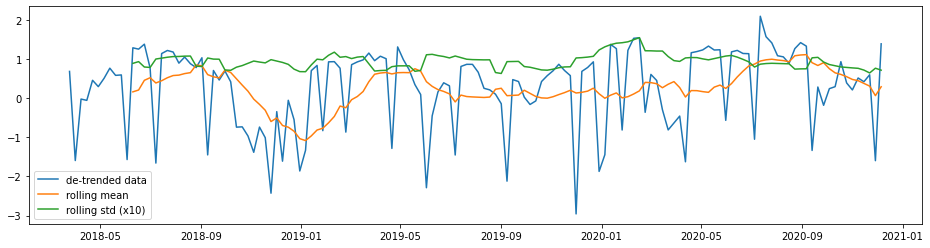

In [7]:
# Detrending
adj_close_detrend =  (adj_close - adj_close.rolling(window=12).mean())/adj_close.rolling(window=12).std()

test_stationarity(adj_close_detrend,'de-trended data')
ADF_test(adj_close_detrend,'de-trended data')

The results show that the data is now stationary, indicated by the relative smoothness of the rolling mean and rolling standard deviation after running the ADF test again.

### Differencing
This method removes the underlying seasonal or cyclical patterns in the time series. Since the sample dataset has a 12-month seasonality, I used a 12-lag difference:

 > Is the 12 lag differenced data stationary ?
Test statistic = -3.880
P-value = 0.002
Critical values :
	1%: -3.482087964046026 - The data is  stationary with 99% confidence
	5%: -2.8842185101614626 - The data is  stationary with 95% confidence
	10%: -2.578864381347275 - The data is  stationary with 90% confidence


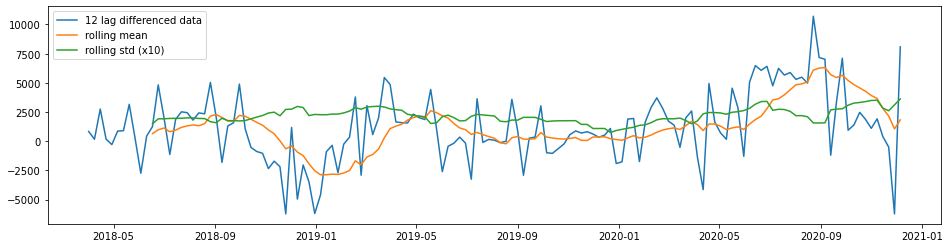

In [8]:
# Differencing
adj_close_12lag =  adj_close - adj_close.shift(12)

test_stationarity(adj_close_12lag,'12 lag differenced data')
ADF_test(adj_close_12lag,'12 lag differenced data')

### Combining Detrending and Differencing

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -5.099
P-value = 0.000
Critical values :
	1%: -3.4870216863700767 - The data is  stationary with 99% confidence
	5%: -2.8863625166643136 - The data is  stationary with 95% confidence
	10%: -2.580009026141913 - The data is  stationary with 90% confidence


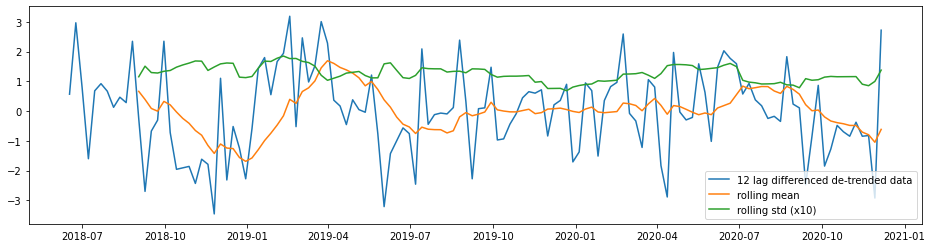

In [9]:
# Detrending + Differencing

adj_close_12lag_detrend =  adj_close_detrend - adj_close_detrend.shift(12)

test_stationarity(adj_close_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(adj_close_12lag_detrend,'12 lag differenced de-trended data')